In [9]:
from os.path import isfile
from pathlib import Path
import numpy as np

from pysbmy.power import PowerSpectrum
from pysbmy.fft import FourierGrid, read_FourierGrid
from pysbmy.field import read_field as _read_field
from pysbmy.correlations import get_autocorrelation

from plot_utils import *
from tools import stdout_redirector

## suppress C stdout for read_file
def read_field(*args):
    import io
    with io.BytesIO() as f:
        with stdout_redirector(f):
            return _read_field(*args)

In [28]:
N0=128
L0=250.0

run_id=2
run_id_list=[0,1,2]

simdir=f"runs_sims/run{run_id}/"

nsteps_pm_list=[200]
nsteps_cola_list=[10,20,50]
nsteps_bullfrog_list=[10,20,50]

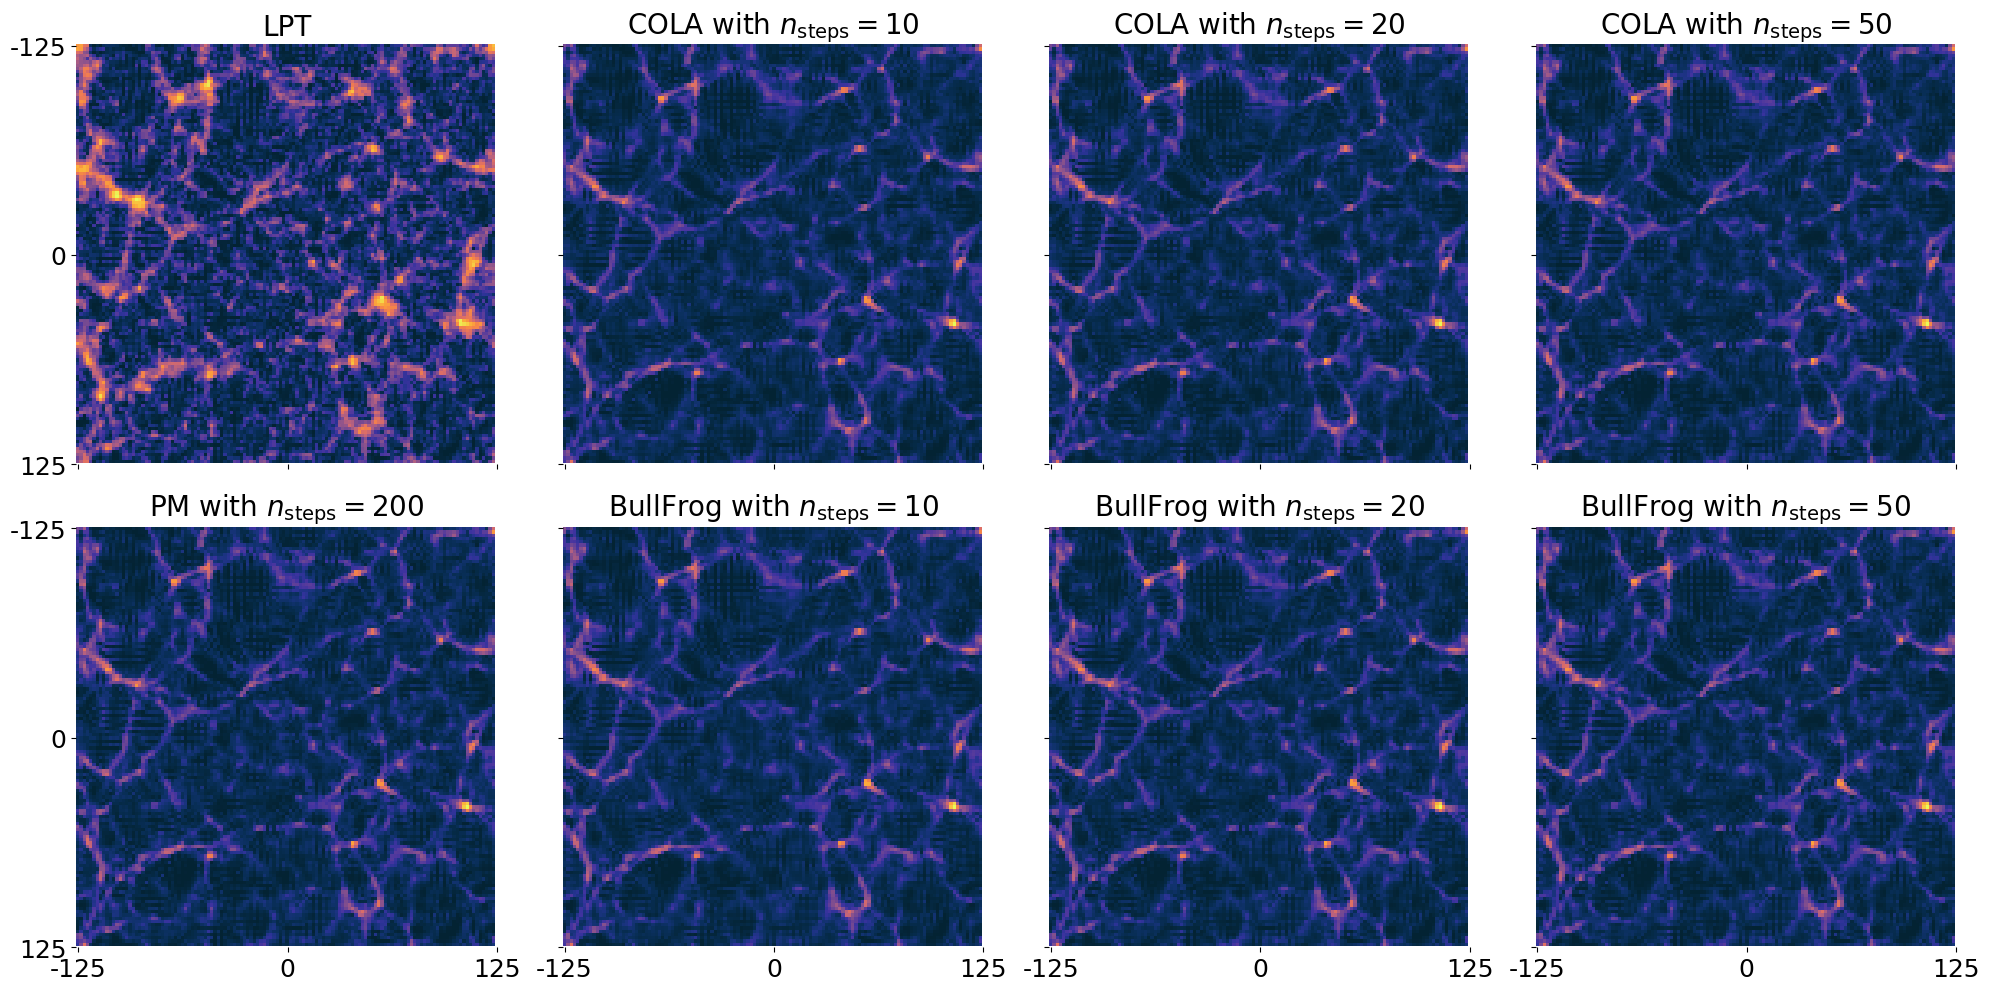

In [29]:
slice_ijk = (N0//2, slice(None), slice(None))
DELTA_LPT = read_field(simdir + "lpt_density.h5").data[slice_ijk]

all_nsteps = sorted(list(set(nsteps_cola_list + nsteps_bullfrog_list)))[:4]

ncols = len(all_nsteps) + 1
nrows = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols,5*nrows), sharex=True, sharey=True)
axs[0, 0].imshow(np.log(2 + DELTA_LPT), cmap=cmap)
axs[0, 0].set_title("LPT", fontsize=fs_titles)
DELTA_PM = read_field(simdir + f"nsteps{max(nsteps_pm_list)}_final_density_pm.h5").data[slice_ijk]
axs[1, 0].imshow(np.log(2 + DELTA_PM), cmap=cmap)
axs[1, 0].set_title(f"PM with $n_\\mathrm{{steps}}={max(nsteps_pm_list)}$", fontsize=fs_titles)
for i, nsteps in enumerate(all_nsteps):
    if nsteps in nsteps_cola_list:
        DELTA_COLA = read_field(simdir + f"nsteps{nsteps}_final_density_cola.h5").data[slice_ijk]
        axs[0,i+1].imshow(np.log(2+DELTA_COLA), cmap=cmap)
        axs[0, i + 1].set_title(f"COLA with $n_\\mathrm{{steps}}={nsteps}$", fontsize=fs_titles)
    if nsteps in nsteps_bullfrog_list:
        DELTA_BULLFROG = read_field(simdir + f"nsteps{nsteps}_final_density_bullfrog.h5").data[slice_ijk]
        axs[1, i + 1].imshow(np.log(2 + DELTA_BULLFROG), cmap=cmap)
        axs[1,i+1].set_title(f"BullFrog with $n_\\mathrm{{steps}}={nsteps}$", fontsize=fs_titles)
for ax in axs.flatten():
    ax.spines[["top", "right", "bottom", "left"]].set_visible(False)
for ax in axs[:,0]:
    ax.set_yticks([0, N0//2, N0])
    ax.set_yticklabels([f"{-L0/2:.0f}", "0", f"{L0/2:.0f}"], fontsize=fs)
for ax in axs[1,:]:
    ax.set_xticks([0, N0//2, N0])
    ax.set_xticklabels([f"{-L0/2:.0f}", "0", f"{L0/2:.0f}"], fontsize=fs)
for i in range(nrows):
    for j in range(ncols):
        if axs[i,j].get_title() == "":
            axs[i,j].axis("off")
plt.tight_layout()
plt.show()

In [20]:
G = read_FourierGrid(simdir + "input_ss_k_grid.h5")
k = G.k_modes[1:]
AliasingCorr = False

DELTA = read_field(simdir + "initial_density.h5")
Pk_INI, Vk_INI = get_autocorrelation(DELTA, G, False)
Pk_INI, Vk_INI = Pk_INI[1:], Vk_INI[1:]
Sk_INI = np.sqrt(Vk_INI)

DELTA = read_field(simdir + "lpt_density.h5")
Pk_LPT, Vk_LPT = get_autocorrelation(DELTA, G, AliasingCorr)
Pk_LPT, Vk_LPT = Pk_LPT[1:], Vk_LPT[1:]
Sk_LPT = np.sqrt(Vk_LPT)

Pk_PM_list = []
Sk_PM_list = []
for nsteps in nsteps_pm_list:
    Pk_PM_list.append([])
    Sk_PM_list.append([])
    for run_id in run_id_list:
        simdir=f"runs_sims/run{run_id}/"
        DELTA = read_field(simdir + f"nsteps{nsteps}_final_density_pm.h5")
        Pk_PM, Vk_PM = get_autocorrelation(DELTA, G, AliasingCorr)
        Pk_PM, Vk_PM = Pk_PM[1:], Vk_PM[1:]
        Sk_PM = np.sqrt(Vk_PM)
        Pk_PM_list[-1].append(Pk_PM)
        Sk_PM_list[-1].append(Sk_PM)

Pk_PM_list=np.array(Pk_PM_list)
Pk_ref = Pk_PM_list[-1].mean(axis=0)

Pk_COLA_list = []
Sk_COLA_list = []
for nsteps in nsteps_cola_list:
    Pk_COLA_list.append([])
    Sk_COLA_list.append([])
    for run_id in run_id_list:
        simdir=f"runs_sims/run{run_id}/"
        DELTA = read_field(simdir + f"nsteps{nsteps}_final_density_cola.h5")
        Pk_COLA, Vk_COLA = get_autocorrelation(DELTA, G, AliasingCorr)
        Pk_COLA, Vk_COLA = Pk_COLA[1:], Vk_COLA[1:]
        Sk_COLA = np.sqrt(Vk_COLA)
        Pk_COLA_list[-1].append(Pk_COLA)
        Sk_COLA_list[-1].append(Sk_COLA)
        
Pk_COLA_list=np.array(Pk_COLA_list)

Pk_BULLFROG_list = []
Sk_BULLFROG_list = []
for nsteps in nsteps_bullfrog_list:
    Pk_BULLFROG_list.append([])
    Sk_BULLFROG_list.append([])
    for run_id in run_id_list:
        simdir=f"runs_sims/run{run_id}/"
        DELTA = read_field(simdir + f"nsteps{nsteps}_final_density_bullfrog.h5")
        Pk_BULLFROG, Vk_BULLFROG = get_autocorrelation(DELTA, G, AliasingCorr)
        Pk_BULLFROG, Vk_BULLFROG = Pk_BULLFROG[1:], Vk_BULLFROG[1:]
        Sk_BULLFROG = np.sqrt(Vk_BULLFROG)
        Pk_BULLFROG_list[-1].append(Pk_BULLFROG)
        Sk_BULLFROG_list[-1].append(Sk_BULLFROG)
        
        
Pk_BULLFROG_list=np.array(Pk_BULLFROG_list)

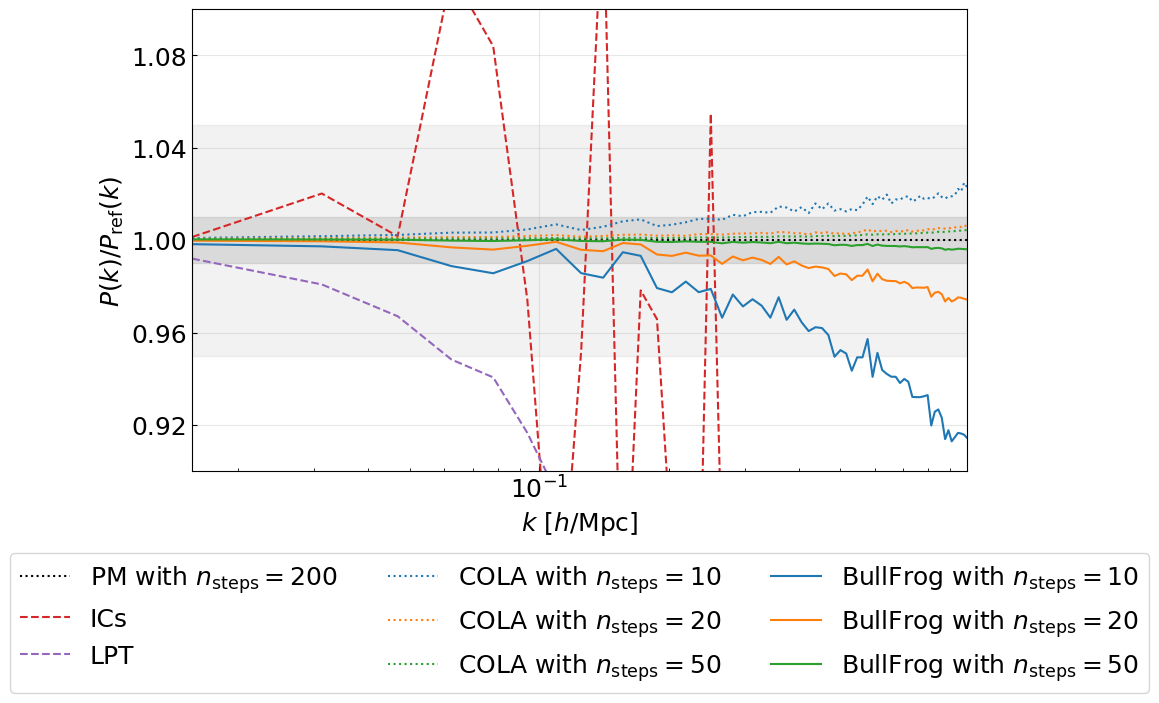

In [22]:
focused = True

common_nsteps = sorted(set(nsteps_cola_list).intersection(nsteps_bullfrog_list))
common_nsteps = [nsteps for nsteps in common_nsteps if nsteps > 2]
nlines = len(common_nsteps) + 2

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xscale("log")
k = G.k_modes[1:]
ax.set_xlim([k.min(), k.max()])
ax.set_ylim([0, 2])  # to be adjusted depending on the setup
ax.set_ylim([0.9, 1.1]) if focused else  ax.set_ylim([0, 2]) 

label_ref = f"PM with $n_\\mathrm{{steps}}={max(nsteps_pm_list)}$"
ax.plot([1e-3, 1e1], [1, 1], color="black", linestyle=":", label=label_ref)
ax.plot(k, Pk_INI / Pk_ref, label="ICs", color=cols[len(common_nsteps)], linestyle="--")
ax.plot(k, Pk_LPT / Pk_ref, label="LPT", color=cols[len(common_nsteps) + 1], linestyle="--")
for i, nsteps in enumerate(nsteps_pm_list[:-1]):
    ax.plot(
        k,
        Pk_PM_list[i].mean(axis=0) / Pk_ref,
        label=f"PM with $n_\\mathrm{{steps}}={nsteps}$",
        linestyle="--",
        color=cols[i],
    )
for i, nsteps in enumerate(common_nsteps):
    ax.plot(
        k,
        Pk_COLA_list[i].mean(axis=0) / Pk_ref,
        label=f"COLA with $n_\\mathrm{{steps}}={nsteps}$",
        linestyle=":",
        color=cols[i],
    )
for i, nsteps in enumerate(common_nsteps):
    ax.plot(
        k,
        Pk_BULLFROG_list[i].mean(axis=0) / Pk_ref,
        label=f"BullFrog with $n_\\mathrm{{steps}}={nsteps}$",
        linestyle="-",
        color=cols[i],
    )
bnd1 = 0.01 if focused else 0.1  # to be adjusted depending on the setup
bnd2 = 0.05 if focused else 0.2  # to be adjusted depending on the setup
ax.axhspan(1 - bnd1, 1 + bnd1, color="grey", alpha=0.2)
ax.axhspan(1 - bnd2, 1 + bnd2, color="grey", alpha=0.1)

ax.grid(alpha=0.3)
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.get_major_ticks()[0].label1.set_visible(False)
ax.set_xlabel("$k$ [$h/\\mathrm{Mpc}$]", fontsize=fs)
ax.set_ylabel("$P(k)/P_\\mathrm{ref}(k)$", fontsize=fs)
ax.tick_params(which="both", direction="in")
ax.tick_params(axis="both", which="major", labelsize=fs)
ax.tick_params(axis="both", which="minor", labelsize=fs)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=fs)

plt.show()

In [23]:
Pk_PM_list[-1].std(axis=0)

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       1.2207031e-04, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       6.1035156e-05, 6.1035156e-05, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 3.0517578e-05, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 3.0517578e-05, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 1.5258789e-05, 0.0000000e+00, 1.5258789e-05,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       1.5258789e-05, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e